<a href="https://colab.research.google.com/github/amanjaiswal777/Tasks/blob/main/Fake_Image_Generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Task_2**: Code for generating fake images that does not exist


**Approach**: I will use GAN to generate fake images.

#What is GAN? 
GAN stands for generative adversial network in which two different models are built to compete with each other.

They both are known as **Generator** and **Discriminator**.

Generator will try to generate fake images such that the fake images would fool the discriminator to identify as real or fake face.

Discriminator will try to difference between real and fake images. It just uses a binary classification algorithm at the end.

**Dataset**: I will use open available dataset from kaggle. Download it and save it to the google drive to call and use it in google colab.

In [1]:
#Mount the google drive

!ls

drive  sample_data


In [2]:
!ls drive/MyDrive

 anime_face_dataset.zip  'Colab Notebooks'   projects
 celeb_face.zip		 'MIT SOP.gdoc'      TASKS.gdoc


In [3]:
!mkdir anime_dataset

In [4]:
!unzip drive/MyDrive/anime_face_dataset.zip -d anime_dataset

Streaming output truncated to the last 5000 lines.
  inflating: anime_dataset/images/62764_2019.jpg  
  inflating: anime_dataset/images/62765_2019.jpg  
  inflating: anime_dataset/images/62766_2019.jpg  
  inflating: anime_dataset/images/62767_2019.jpg  
  inflating: anime_dataset/images/62768_2019.jpg  
  inflating: anime_dataset/images/62769_2019.jpg  
  inflating: anime_dataset/images/6276_2003.jpg  
  inflating: anime_dataset/images/62770_2019.jpg  
  inflating: anime_dataset/images/62771_2019.jpg  
  inflating: anime_dataset/images/62772_2019.jpg  
  inflating: anime_dataset/images/62773_2019.jpg  
  inflating: anime_dataset/images/62774_2019.jpg  
  inflating: anime_dataset/images/62775_2019.jpg  
  inflating: anime_dataset/images/62776_2019.jpg  
  inflating: anime_dataset/images/62777_2019.jpg  
  inflating: anime_dataset/images/62778_2019.jpg  
  inflating: anime_dataset/images/62779_2019.jpg  
  inflating: anime_dataset/images/6277_2003.jpg  
  inflating: anime_dataset/images

In [5]:
data_dir = "anime_dataset"

In [6]:
#Lets calculate the total number of images present in the images folder. For that I need to import os 
import os
j = 0
for i in os.listdir(data_dir + '/images'):
  j+=1

print(j)

63565


ImageFolder class will be used to load the dataset and further normalization and resize of image will happen which requires torchvision transforms library.

In [7]:
#import the necessary library
from torch.utils.data import DataLoader 
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [9]:
#images will be cropped to 64 * 64 size
image_size = 64
#In a single batch 128 images will be passed to dataloader
batch_size = 128
#mean and standard deviation for normalisation of images is set to 0.5 so that the pixel values are brought up between -1 and 1 for discriminator to train properly
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [11]:
train_ds = ImageFolder(data_dir, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)

In [12]:
#Lets visualize the images once

#For that we need the real state of the images whose pixels ranges between 0 to 1

#Creating a helper function
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [13]:
#Importing libraries to plot
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [14]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

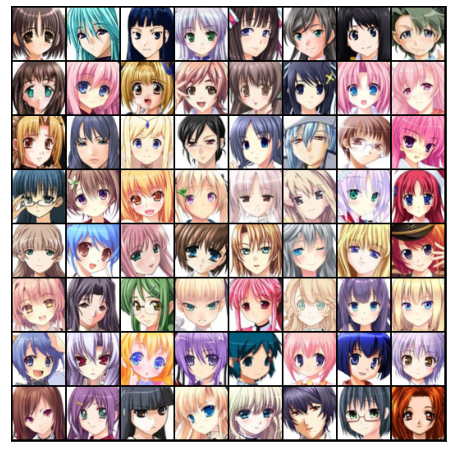

In [15]:
show_batch(train_dl)

#GPU uses

In [16]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [17]:
device = get_default_device()
device

device(type='cuda')

In [18]:
train_dl = DeviceDataLoader(train_dl, device)

In [19]:
import torch.nn as nn

In [20]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())


In [21]:
discriminator = to_device(discriminator, device)

In [22]:
latent_size = 128

In [23]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)


torch.Size([128, 3, 64, 64])


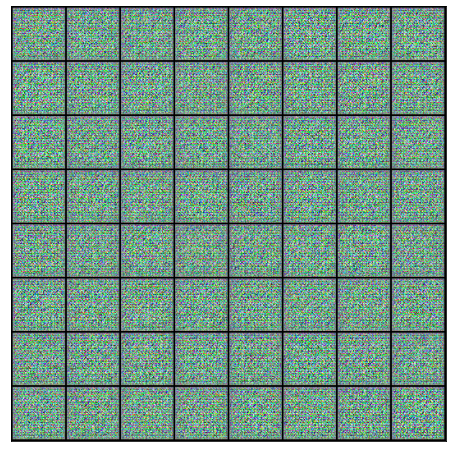

In [24]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [25]:
generator = to_device(generator, device)

In [26]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [27]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [28]:
from torchvision.utils import save_image

In [29]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [30]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))


In [31]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-images-0000.png


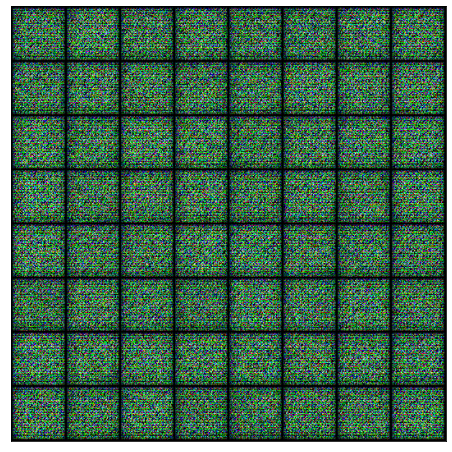

In [32]:
save_samples(0, fixed_latent)


In [33]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [34]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [35]:
lr = 0.0002
epochs = 15

In [36]:
history = fit(epochs, lr)

  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [1/15], loss_g: 4.2974, loss_d: 0.5274, real_score: 0.6740, fake_score: 0.0460
Saving generated-images-0001.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [2/15], loss_g: 6.1551, loss_d: 0.6485, real_score: 0.8904, fake_score: 0.3765
Saving generated-images-0002.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [3/15], loss_g: 6.3818, loss_d: 0.2832, real_score: 0.9449, fake_score: 0.1832
Saving generated-images-0003.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [4/15], loss_g: 3.9474, loss_d: 0.2629, real_score: 0.8684, fake_score: 0.0824
Saving generated-images-0004.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [5/15], loss_g: 8.5963, loss_d: 0.5942, real_score: 0.6644, fake_score: 0.0008
Saving generated-images-0005.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [6/15], loss_g: 6.2343, loss_d: 0.3806, real_score: 0.9173, fake_score: 0.2143
Saving generated-images-0006.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [7/15], loss_g: 3.0417, loss_d: 0.2769, real_score: 0.8337, fake_score: 0.0663
Saving generated-images-0007.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [8/15], loss_g: 5.0055, loss_d: 0.1640, real_score: 0.9199, fake_score: 0.0671
Saving generated-images-0008.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [9/15], loss_g: 6.3610, loss_d: 0.2670, real_score: 0.9853, fake_score: 0.1959
Saving generated-images-0009.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [10/15], loss_g: 5.9984, loss_d: 0.3233, real_score: 0.9689, fake_score: 0.2212
Saving generated-images-0010.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [11/15], loss_g: 3.5464, loss_d: 0.3899, real_score: 0.9907, fake_score: 0.2608
Saving generated-images-0011.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [12/15], loss_g: 3.5613, loss_d: 0.2240, real_score: 0.8688, fake_score: 0.0591
Saving generated-images-0012.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [13/15], loss_g: 4.6132, loss_d: 0.0981, real_score: 0.9389, fake_score: 0.0256
Saving generated-images-0013.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [14/15], loss_g: 1.4317, loss_d: 0.8064, real_score: 0.5476, fake_score: 0.0021
Saving generated-images-0014.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [15/15], loss_g: 4.0013, loss_d: 0.1879, real_score: 0.9268, fake_score: 0.0935
Saving generated-images-0015.png


In [37]:
losses_g, losses_d, real_scores, fake_scores = history

In [38]:
# Save the model checkpoints 
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

In [39]:
from IPython.display import Image

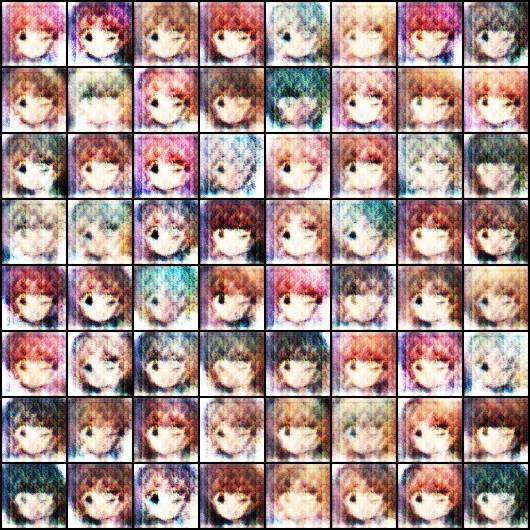

In [40]:
Image('./generated/generated-images-0001.png')

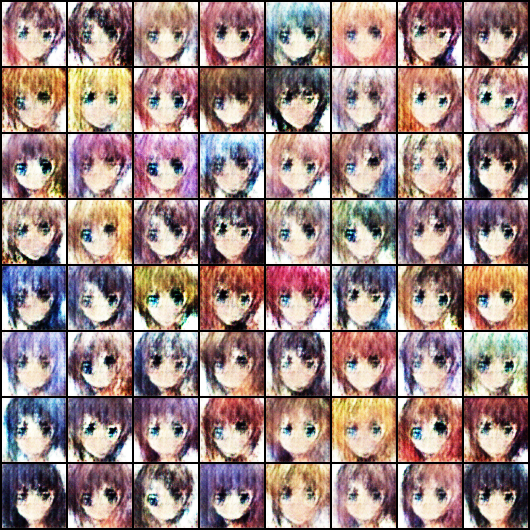

In [41]:
Image('./generated/generated-images-0002.png')

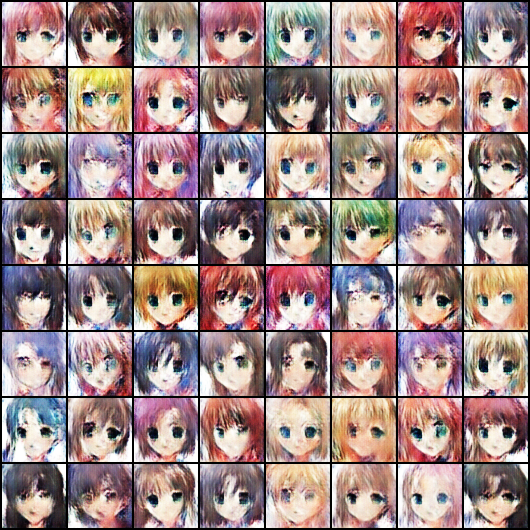

In [42]:
Image('./generated/generated-images-0005.png')

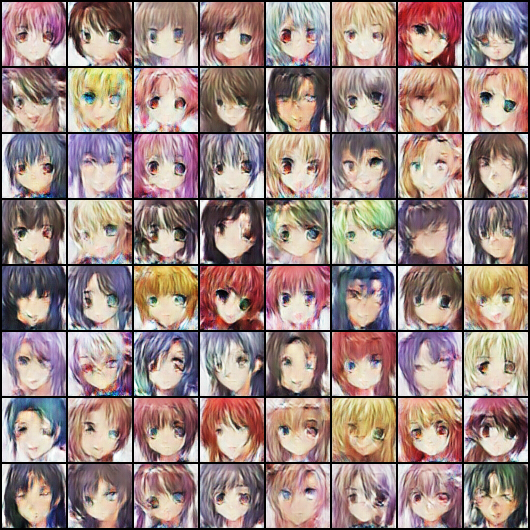

In [43]:
Image('./generated/generated-images-0010.png')

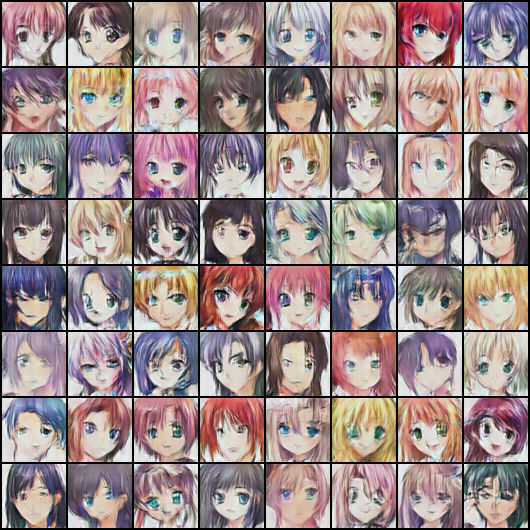

In [44]:
Image('./generated/generated-images-0015.png')

In [46]:
import cv2
import os

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

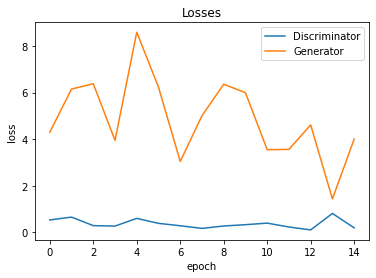

In [47]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

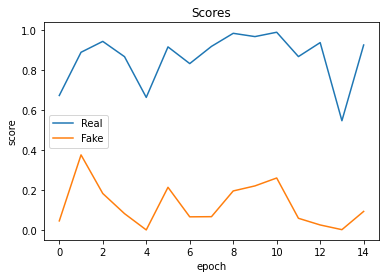

In [48]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');